In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import os
import math

# import data

In [100]:
def fix_mat(data):
    if data.dtype.names:
        new_data = dict()
        for name in data.dtype.names:
            new_data[name]=data[0][name][0]
        for k,v in new_data.items():
            if v.dtype.names:
                new_data[k] = fix_mat(v)
            else:
                new_data[k] = np.squeeze(v)
        return new_data
    else:
        return data

In [143]:
data_name = 'data_c7_11112025_192031'
ext = '.mat'
path = './datasets/' + data_name + ext
data = loadmat(path)
classes = fix_mat(data['classes'][0])
percentual_train = 0.75
idx_ch_occipital = fix_mat(data['ch_occipital']).ravel() - 1  # -1 for python indexing
ch_occipital = fix_mat(data['occipital']).ravel()  
files = fix_mat(data['filenames'])
subject = data_name[5:7] # fixed position for the subject code
day = data_name[8:] # fixed position for the day code
kmeans_file = fix_mat(data['kmeans_file'])

X = fix_mat(data['X'])
X = np.log(X)
y = fix_mat(data['y']).ravel()

# take only the correct percentual for training and testing
c1_X = X[y == classes[0]]
c2_X = X[y == classes[1]]
X_train_c1 = c1_X[:math.ceil(len(c1_X)*percentual_train)]
X_train_c2 = c2_X[:math.ceil(len(c2_X)*percentual_train)]
X_test_c1 = c1_X[math.ceil(len(c1_X)*percentual_train):]
X_test_c2 = c2_X[math.ceil(len(c2_X)*percentual_train):]
X_train = np.vstack((X_train_c1, X_train_c2))
y_train = np.hstack((np.ones(X_train_c1.shape[0])*classes[0], np.ones(X_train_c2.shape[0])*classes[1]))
X_test = np.vstack((X_test_c1, X_test_c2))
y_test = np.hstack((np.ones(X_test_c1.shape[0])*classes[0], np.ones(X_test_c2.shape[0])*classes[1]))

X_train = X_train[:, idx_ch_occipital]
X_test  = X_test[:, idx_ch_occipital]
X = X[:, idx_ch_occipital]

print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (948, 17) (948,)
Test set: (315, 17) (315,)


/tmp/ipykernel_62191/129560253.py:15: RuntimeWarning: divide by zero encountered in log
  X = np.log(X)


# Usefull functions

In [96]:
def print_cm(cm, title, tick_labels):

    # Create a heatmap
    plt.figure(figsize=(3,2))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    
    # Add labels and titles
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()
    

def print_cm_rej(model, X, y_true, th_rej, title, ticket_label):
    cm = [[0, 0], [0, 0]]
    y_probs = model.predict_proba(X)
    count_integrated = 0
    
    for idx_p in range(len(y_probs)):
        if y_true[idx_p] == 730 and y_probs[idx_p,0] > th_rej[0]:
            cm[0][0] += 1 
            count_integrated = count_integrated + 1
        elif y_true[idx_p] == 730 and y_probs[idx_p, 1] > th_rej[0]:
            cm[0][1] += 1
            count_integrated = count_integrated + 1
        elif y_true[idx_p] == 731 and y_probs[idx_p, 1] > th_rej[1]:
            cm[1][1] += 1
            count_integrated = count_integrated + 1
        elif y_true[idx_p] == 731 and y_probs[idx_p, 0] > th_rej[1]:
            cm[1][0] += 1
            count_integrated = count_integrated + 1
    
    # print accuracy
    print('Accuracy:', np.trace(cm)/np.sum(cm))
    print('Accuracy 730:', cm[0][0]/(cm[0][0]+cm[0][1]))
    print('Accuracy 731:', cm[1][1]/(cm[1][0]+cm[1][1]))
    print('Integrated: ', count_integrated, ' percentual: ', count_integrated/len(y_probs), '%')   
    print_cm(cm, title, ticket_label)
    
    
def histo_prediction(X, y, model, bins_step, classes):
    probs = model.predict_proba(X)
    y_pred = model.predict(X)

    correct_mask = (y_pred == y)
    incorrect_mask = (y_pred != y)

    probs_class_0 = probs[:, 0]
    
    probs_correct = probs_class_0[correct_mask]
    probs_incorrect = probs_class_0[incorrect_mask]

    bins = np.arange(0, 1.0 + bins_step, bins_step)

    figure = plt.figure(figsize=(8, 5)) 
    plt.hist(
        [probs_correct, probs_incorrect], 
        bins=bins, 
        stacked=True, 
        color=['#28a745', '#dc3545'], # Color: green (correct), red (wrong)
        label=['Correctly classified', 'Wrongly classified']
    )

    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.title(f'Probability distribution class: {classes[0]}')
    plt.xlabel(f'Probability class {classes[0]}')
    plt.ylabel('Frequency')
    plt.legend() 

    plt.show()
    

# QDA

In [85]:
param_grid = {'reg_param': [0.0, 0.1, 0.5, 1.0], 'priors': [None, [0.5, 0.5]]}

#grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=3).fit(X_train, y_train)
grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1).fit(X, y)

#print("Results: ", grid_search.cv_results_)
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.7086297760210805


In [86]:
model_qda = QuadraticDiscriminantAnalysis(reg_param=grid_search.best_params_['reg_param'], store_covariance=True, priors=grid_search.best_params_['priors'])
model_qda.fit(X_train, y_train)

print(f'Accuracy train: {model_qda.score(X_train, y_train)}')
print(f'Accuracy test:  {model_qda.score(X_test, y_test)}')
print(f'Accuracy all:   {model_qda.score(X, y)}')

Accuracy train: 0.7141350210970464
Accuracy test:  0.6888888888888889
Accuracy all:   0.7078384798099763


In [75]:
# train over all the dataset
model_qda = QuadraticDiscriminantAnalysis(reg_param=grid_search.best_params_['reg_param'], store_covariance=True, priors=grid_search.best_params_['priors'])
model_qda.fit(X, y)

print(f'Accuracy all:   {model_qda.score(X, y)}')

Accuracy all:   0.7078384798099763


Accuracy: 0.7141350210970464
Accuracy 730: 0.6946236559139785
Accuracy 731: 0.7329192546583851
Integrated:  948  percentual:  1.0 %


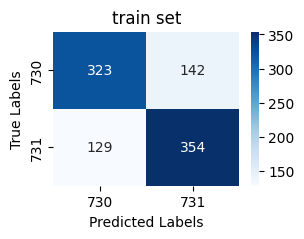

Accuracy: 0.6888888888888889
Accuracy 730: 0.8258064516129032
Accuracy 731: 0.55625
Integrated:  315  percentual:  1.0 %


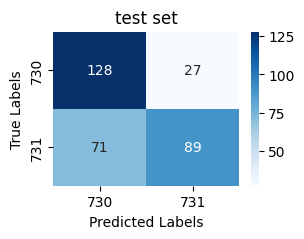

Accuracy: 0.7078384798099763
Accuracy 730: 0.7274193548387097
Accuracy 731: 0.6889580093312597
Integrated:  1263  percentual:  1.0 %


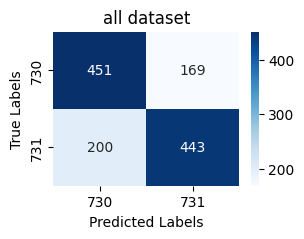

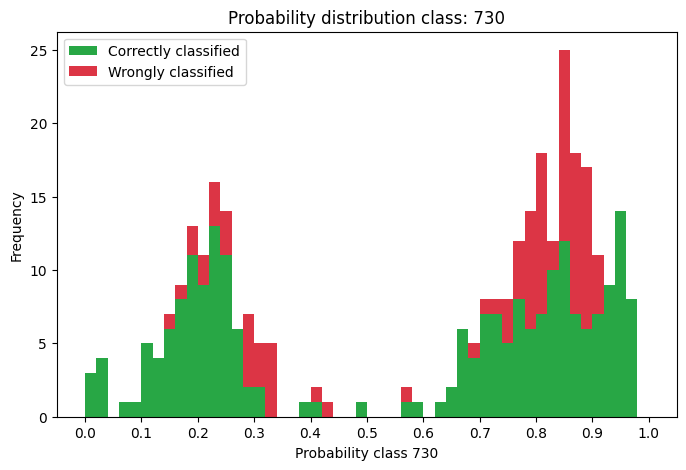

In [97]:
ths_rej = [0.5, 0.5]
bins_step = 0.02

print_cm_rej(model_qda, X_train, y_train, ths_rej, 'train set',  ['730', '731'])
print_cm_rej(model_qda, X_test,  y_test,  ths_rej, 'test set',  ['730', '731'])
print_cm_rej(model_qda, X,  y,  ths_rej, 'all dataset',  ['730', '731'])

histo_prediction(X_test, y_test, model_qda, bins_step, classes)

# Save QDA

In [144]:
# save qda model for sklearn
from ruamel.yaml import YAML
from ruamel.yaml.scalarstring import LiteralScalarString

files_str = []
for i in range(0, len(files[0])):
    str_file = files[0][1]
    files_str.append(str(str_file))
    
features_label = []
for i in range(0, len(ch_occipital)):
    str_ch = ch_occipital[i][0]
    features_label.append(str(str_ch))
    

model_params = {
    'QdaCfg': {
        'name': "qda",
        'params': {
            'subject': subject,
            'filename': 'qda',
            'filename_dataset': path,
            'files_dataset': files_str,
            'kmeans_file': str(kmeans_file[0]),
            'nclasses': int(len(model_qda.classes_)),
            'classlbs': model_qda.classes_.tolist(),
            'nfeatures': int(model_qda.n_features_in_),
            'note': 'idchannels are saved in matlab convention, instead channels are the used one (=channels_labels(idchanels in matlab))',
            'channels': features_label,
            'idchannels': (idx_ch_occipital + 1).tolist(), 
            
            'reg_param': float(model_qda.reg_param),
            'priors': model_qda.priors_.tolist(),
            'means': model_qda.means_.tolist(),
            'covs': [arr.tolist() for arr in model_qda.covariance_],
            'rotations': [arr.tolist() for arr in model_qda.rotations_],
            'scalings': [arr.tolist() for arr in model_qda.scalings_]
        }
    }
}

# Save parameters to a YAML file
c_dir = os.getcwd()
c_prev = os.path.abspath(os.path.join(c_dir, os.pardir))
path2save = c_prev + '/cfg/qda_' + subject + '_' + day + '.yaml'

yaml = YAML()
with open(path2save, 'w') as file:
    yaml.dump(model_params, file)
    
print(path2save)

/home/paolo/cvsa/ic_cvsa_ws/src/qda_cvsa/cfg/qda_c7_11112025_192031.yaml
